<a href="https://colab.research.google.com/github/111DataScienceWizard/TREBIRTH/blob/main/Collab%20Notes/TFLite_Keras_model_in_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

installing important libraries

In [ ]:
!pip install tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.7/455.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 29.8 MB/s eta 0:00:00


importing necessary libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tf2onnx import convert
from tensorflow import keras

defining rollingstatistics function to extract features

In [ ]:
class RollingStatisticsExtractor:
    def __init__(self, window_size):
        self.window_size = window_size

    def fit(self, data):
        self.data = data
        return self

    def transform(self, data):
        rolling_statistics = data.rolling(window=self.window_size, min_periods=5)
        aggregated_features = pd.DataFrame()

        for column in data.columns:
            aggregated_features[f'{column}_mean'] = rolling_statistics[column].mean()
            aggregated_features[f'{column}_median'] = rolling_statistics[column].median()
            aggregated_features[f'{column}_std'] = rolling_statistics[column].std()
            aggregated_features[f'{column}_rms'] = rolling_statistics[column].apply(lambda x: np.sqrt(np.mean(x ** 2)))
            aggregated_features[f'{column}_peak2peak'] = rolling_statistics[column].max() - rolling_statistics[column].min()

        aggregated_features = aggregated_features.dropna()
        return aggregated_features

    def fit_transform(self, data):
        return self.fit(data).transform(data)


In [ ]:
def add_labels(df, label):
    df['label'] = label
    return df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


loading the data

In [ ]:
healthy_data_1 = add_labels(pd.read_excel('/content/drive/MyDrive/New Version/HealthyS1_ButtonTop.xlsx'), 'healthy')
healthy_data_2 = add_labels(pd.read_excel('/content/drive/MyDrive/New Version/HealthyS2_ButtonRight.xlsx'), 'healthy')
healthy_data_3 = add_labels(pd.read_excel('/content/drive/MyDrive/New Version/HealthyS3_ButtonBottom.xlsx'), 'healthy')

In [ ]:
infected_data_1 = add_labels(pd.read_excel('/content/drive/MyDrive/New Version/Handheld_I1.xlsx'), 'Infected')
infected_data_2 = add_labels(pd.read_excel('/content/drive/MyDrive/New Version/Handheld_I2.xlsx'), 'Infected')
infected_data_3 = add_labels(pd.read_excel('/content/drive/MyDrive/New Version/Handheld_I3.xlsx'), 'Infected')

concatenating the data

In [ ]:
healthy_data = pd.concat([healthy_data_1, healthy_data_2, healthy_data_3])
infected_data= pd.concat([infected_data_1, infected_data_2, infected_data_3])

giving window size and extractor

In [ ]:
window_size = 500
extractor = RollingStatisticsExtractor(window_size)

In [ ]:
numeric_columns1 = healthy_data.select_dtypes(include=np.number).columns
numeric_columns2 = infected_data.select_dtypes(include=np.number).columns

EXracting the features from extractor

In [ ]:
healthy_aggregated_features = extractor.fit_transform(healthy_data[numeric_columns1])
infected_aggregated_features = extractor.fit_transform(infected_data[numeric_columns2])

In [ ]:
print(healthy_aggregated_features.isnull().sum())

Radar ADC_mean             0
Radar ADC_median           0
Radar ADC_std              0
Radar ADC_rms              0
Radar ADC_peak2peak        0
LSM Magnitude_mean         0
LSM Magnitude_median       0
LSM Magnitude_std          0
LSM Magnitude_rms          0
LSM Magnitude_peak2peak    0
X-axis_mean                0
X-axis_median              0
X-axis_std                 0
X-axis_rms                 0
X-axis_peak2peak           0
Y-axis_mean                0
Y-axis_median              0
Y-axis_std                 0
Y-axis_rms                 0
Y-axis_peak2peak           0
Z-Axis_mean                0
Z-Axis_median              0
Z-Axis_std                 0
Z-Axis_rms                 0
Z-Axis_peak2peak           0
dtype: int64


In [ ]:
healthy_data_reset = healthy_data.reset_index(drop=True)
infected_data_reset = infected_data.reset_index(drop=True)

In [ ]:
healthy_aggregated_features_reset = healthy_aggregated_features.reset_index(drop=True)
infected_aggregated_features_reset = infected_aggregated_features.reset_index(drop=True)

In [ ]:
healthy_data_with_features = pd.concat([healthy_data_reset, healthy_aggregated_features_reset], axis=1)
infected_data_with_features = pd.concat([infected_data_reset, infected_aggregated_features_reset], axis=1)

defining functions to perform EDA

In [ ]:
def perform_eda(data):
    print("Data Information:")
    print(data.info())

    print("\nData head:")
    print(data.head())

    print("\nData Columns:")
    print(data.columns)

    print("\nData Shape:")
    print(data.shape)

    print("\nData types:")
    print(data.dtypes)

    print("\nData Summary Statistics:")
    print(data.describe())

    print("\nMissing Values:")
    print(data.isnull().sum())

    print("\nUnique Values:")
    for column in data.columns:
        print(f"{column}: {data[column].nunique()} unique values")

    print("\nValue Counts:")
    for column in data.columns:
        print(f"{column}:\n{data[column].value_counts()}\n")

    print("\nCorrelation Map:")
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Correlation Map')
    plt.show()


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7801 entries, 0 to 7800
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Radar ADC                7801 non-null   int64  
 1   LSM Magnitude            7801 non-null   float64
 2   X-axis                   7801 non-null   float64
 3   Y-axis                   7801 non-null   float64
 4   Z-Axis                   7801 non-null   float64
 5   label                    7801 non-null   object 
 6   Radar ADC_mean           7797 non-null   float64
 7   Radar ADC_median         7797 non-null   float64
 8   Radar ADC_std            7797 non-null   float64
 9   Radar ADC_rms            7797 non-null   float64
 10  Radar ADC_peak2peak      7797 non-null   float64
 11  LSM Magnitude_mean       7797 non-null   float64
 12  LSM Magnitude_median     7797 non-null   float64
 13  LSM Magnitude_std        7797 non-null   float64
 14  LSM Ma

<ipython-input-16-6516439d1087>:33: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=.5)


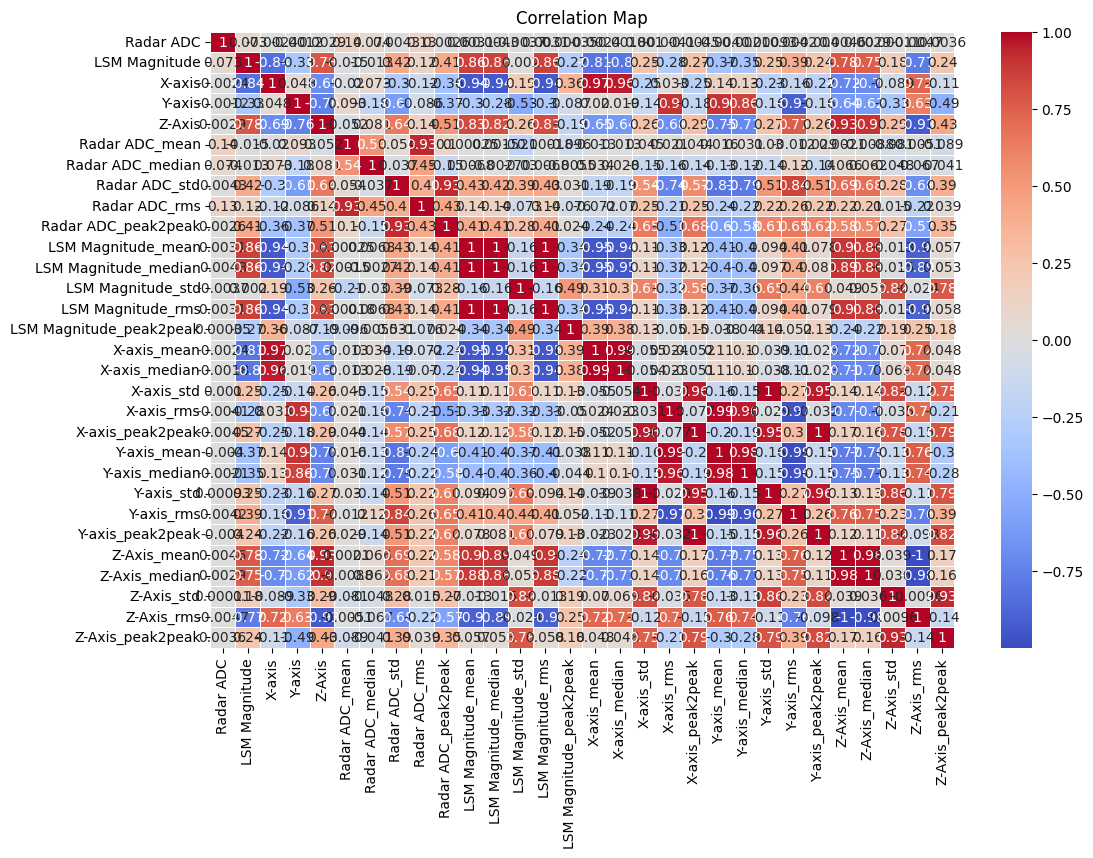

In [ ]:
perform_eda(healthy_data_with_features)

In [ ]:
healthy_data_with_features_cleaned = healthy_data_with_features.dropna()

In [ ]:
for i in healthy_data_with_features.columns:
    print(i)
    print(healthy_data_with_features[i].nunique())
    print(healthy_data_with_features[i].unique())

Radar ADC
519
[2103 2111 2105 2098 2119 2117 2120 2118 2062 2064 2059 2060 2031 2037
 2051 2068 2160 2164 2168 2162 2093 2087 2100 2088 1984 1972 1954 1968
 1952 1955 1967 1959 1945 1944 1951 1964 1935 1939 1987 1990 2000 1996
 2018 2028 2025 2016 1975 1977 1985 1995 2005 2009 2076 2080 2075 2107
 2112 2108 2104 2034 2036 2052 2040 2057 2054 2063 2069 2055 2026 2029
 2038 2041 2019 2011 2010 2012 2022 2013 2048 2053 2097 2115 2102 2127
 2128 2008 2020 2030 2046 2044 2049 2056 2050 2061 2033 2023 2042 2015
 2027 2043 2066 2077 2089 2085 2091 1969 1948 1961 1999 2021 2078 2086
 2096 2032 2017 2004 1946 1933 1950 1943 2003 2073 2101 2124 1958 2035
 2099 2094 2092 2047 2123 2140 2125 2136 1978 1973 1960 2045 2079 2082
 2126 2129 2109 2106 2071 2014 1988 2024 1992 2007 2039 2072 2122 2208
 2200 2199 2149 2144 1938 1966 1931 1917 1923 1983 2083 2074 2081 2084
 1997 2002 2001 2070 1991 1993 2133 2134 2142 2151 2242 2247 2245 2130
 1982 1971 1957 1942 1934 1949 1994 1953 1980 1974 1986 2154 21

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Radar ADC                10314 non-null  int64  
 1   LSM Magnitude            10314 non-null  float64
 2   X-axis                   10314 non-null  float64
 3   Y-axis                   10314 non-null  float64
 4   Z-Axis                   10314 non-null  float64
 5   label                    10314 non-null  object 
 6   Radar ADC_mean           10310 non-null  float64
 7   Radar ADC_median         10310 non-null  float64
 8   Radar ADC_std            10310 non-null  float64
 9   Radar ADC_rms            10310 non-null  float64
 10  Radar ADC_peak2peak      10310 non-null  float64
 11  LSM Magnitude_mean       10310 non-null  float64
 12  LSM Magnitude_median     10310 non-null  float64
 13  LSM Magnitude_std        10310 non-null  float64
 14  LSM 

<ipython-input-16-6516439d1087>:33: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=.5)


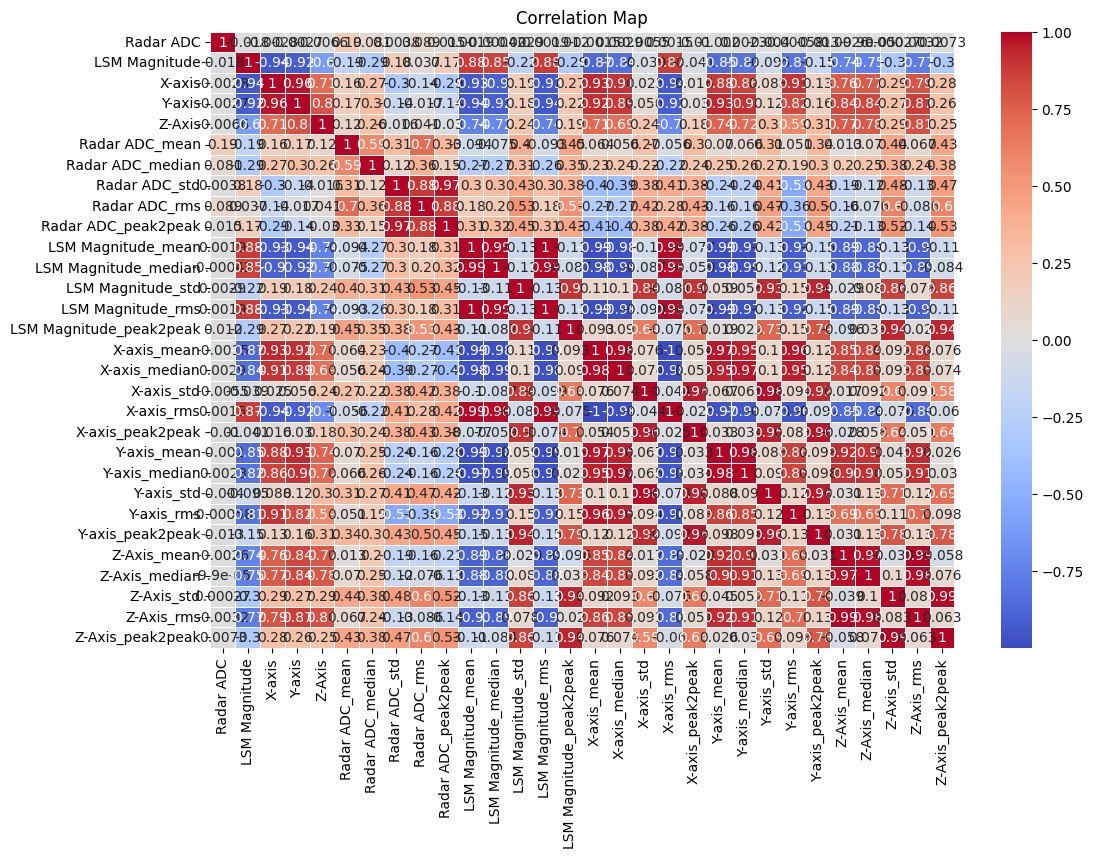

In [ ]:
perform_eda(infected_data_with_features)

In [ ]:
infected_data_with_features_cleaned = infected_data_with_features.dropna()


In [ ]:
for i in infected_data_with_features.columns:
    print(i)
    print(infected_data_with_features[i].nunique())
    print(infected_data_with_features[i].unique())

Radar ADC
1631
[1710 1949 1951 ... 1186 1524 1530]
LSM Magnitude
3819
[1.00752497 1.01319969 1.00868499 ... 1.01088977 1.01109588 1.00861847]
X-axis
691
[-0.76159668 -0.76489258 -0.76196289 -0.75952148 -0.76330566 -0.75964355
 -0.7578125  -0.75744629 -0.76123047 -0.76245117 -0.76477051 -0.76513672
 -0.7644043  -0.76135254 -0.76147461 -0.75878906 -0.75830078 -0.76538086
 -0.76574707 -0.76220703 -0.76379395 -0.76000977 -0.76367188 -0.76623535
 -0.76831055 -0.76269531 -0.76086426 -0.76318359 -0.76171875 -0.76208496
 -0.76391602 -0.76428223 -0.76293945 -0.76403809 -0.76501465 -0.76782227
 -0.76757812 -0.7635498  -0.76464844 -0.76745605 -0.76257324 -0.76599121
 -0.76098633 -0.76074219 -0.76696777 -0.75817871 -0.76586914 -0.76733398
 -0.76953125 -0.7623291  -0.7668457  -0.76306152 -0.76635742 -0.76550293
 -0.765625   -0.76281738 -0.76721191 -0.76879883 -0.76708984 -0.76672363
 -0.7677002  -0.77185059 -0.76416016 -0.76452637 -0.76660156 -0.76928711
 -0.76855469 -0.76843262 -0.76794434 -0.7717

giving labels

In [ ]:
healthy_data_with_features_cleaned['label'] = 0
infected_data_with_features_cleaned['label'] = 1

<ipython-input-23-7fe8dc644330>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy_data_with_features_cleaned['label'] = 0
<ipython-input-23-7fe8dc644330>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infected_data_with_features_cleaned['label'] = 1


concatenating the train data

In [ ]:
train_data = pd.concat([healthy_data_with_features_cleaned,
                      infected_data_with_features_cleaned,
                      ],
                     ignore_index=True)

In [ ]:
train_data.head()

,Radar ADC,LSM Magnitude,X-axis,Y-axis,Z-Axis,label,Radar ADC_mean,Radar ADC_median,Radar ADC_std,Radar ADC_rms,...,Y-axis_mean,Y-axis_median,Y-axis_std,Y-axis_rms,Y-axis_peak2peak,Z-Axis_mean,Z-Axis_median,Z-Axis_std,Z-Axis_rms,Z-Axis_peak2peak
0,2103,0.995339,0.940552,-0.031982,-0.324097,0,2107.200000,2105.0,8.074652,2107.212377,...,-0.030688,-0.031982,0.002893,0.030797,0.006470,-0.323730,-0.324097,0.000819,0.323731,0.001831
1,2111,0.995339,0.940552,-0.031982,-0.324097,0,2108.833333,2108.0,8.256311,2108.846802,...,-0.029826,-0.031982,0.003341,0.029981,0.006470,-0.323486,-0.324097,0.000946,0.323487,0.001831
2,2105,0.995339,0.940552,-0.031982,-0.324097,0,2110.428571,2111.0,8.638232,2110.443725,...,-0.029210,-0.031982,0.003458,0.029385,0.006470,-0.323312,-0.324097,0.000979,0.323313,0.001831
3,2098,0.995339,0.940552,-0.031982,-0.324097,0,2111.375000,2114.0,8.433564,2111.389738,...,-0.028595,-0.028748,0.003643,0.028797,0.007690,-0.323334,-0.323792,0.000908,0.323335,0.001831
4,2119,0.996173,0.942261,-0.025513,-0.322266,0,2105.888889,2111.0,18.251332,2105.959190,...,-0.029066,-0.031982,0.003690,0.029274,0.008545,-0.323473,-0.324097,0.000946,0.323474,0.002319


loadingthe test data

In [ ]:
h_d1 = add_labels(pd.read_excel('/content/drive/MyDrive/New Version/HealthyS4_ButtonLeft.xlsx'), 'healthy')

In [ ]:
i_d1 = add_labels(pd.read_excel('/content/drive/MyDrive/New Version/Handheld_I4.xlsx'), 'Infected')
i_d2 = add_labels(pd.read_excel('/content/drive/MyDrive/New Version/Handheld_I5.xlsx'), 'Infected')

concatenating the data

In [ ]:
h_d = pd.concat([h_d1])
i_d= pd.concat([i_d1, i_d2])

In [ ]:
numeric_columns4 = h_d.select_dtypes(include=np.number).columns
numeric_columns5 = i_d.select_dtypes(include=np.number).columns

extracting features from the test data

In [ ]:
h_d_aggregated_features = extractor.fit_transform(h_d[numeric_columns4])
i_d_aggregated_features = extractor.fit_transform(i_d[numeric_columns5])

Avoiding Unwanted Index as a Column
Creating a Continuous Numeric Index
Compatibility with Operations

In [ ]:
h_d_reset = h_d.reset_index(drop=True)
i_d_reset = i_d.reset_index(drop=True)

In [ ]:
h_d_aggregated_features_reset = h_d_aggregated_features.reset_index(drop=True)
i_d_aggregated_features_reset = i_d_aggregated_features.reset_index(drop=True)

In [ ]:
h_d_with_features = pd.concat([h_d_reset, h_d_aggregated_features_reset], axis=1)
i_d_with_features = pd.concat([i_d_reset, i_d_aggregated_features_reset], axis=1)

performing EDA on test data

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Radar ADC                2329 non-null   int64  
 1   LSM Magnitude            2329 non-null   float64
 2   X-axis                   2329 non-null   float64
 3   Y-axis                   2329 non-null   float64
 4   Z-Axis                   2329 non-null   float64
 5   label                    2329 non-null   object 
 6   Radar ADC_mean           2325 non-null   float64
 7   Radar ADC_median         2325 non-null   float64
 8   Radar ADC_std            2325 non-null   float64
 9   Radar ADC_rms            2325 non-null   float64
 10  Radar ADC_peak2peak      2325 non-null   float64
 11  LSM Magnitude_mean       2325 non-null   float64
 12  LSM Magnitude_median     2325 non-null   float64
 13  LSM Magnitude_std        2325 non-null   float64
 14  LSM Ma

<ipython-input-16-6516439d1087>:33: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=.5)


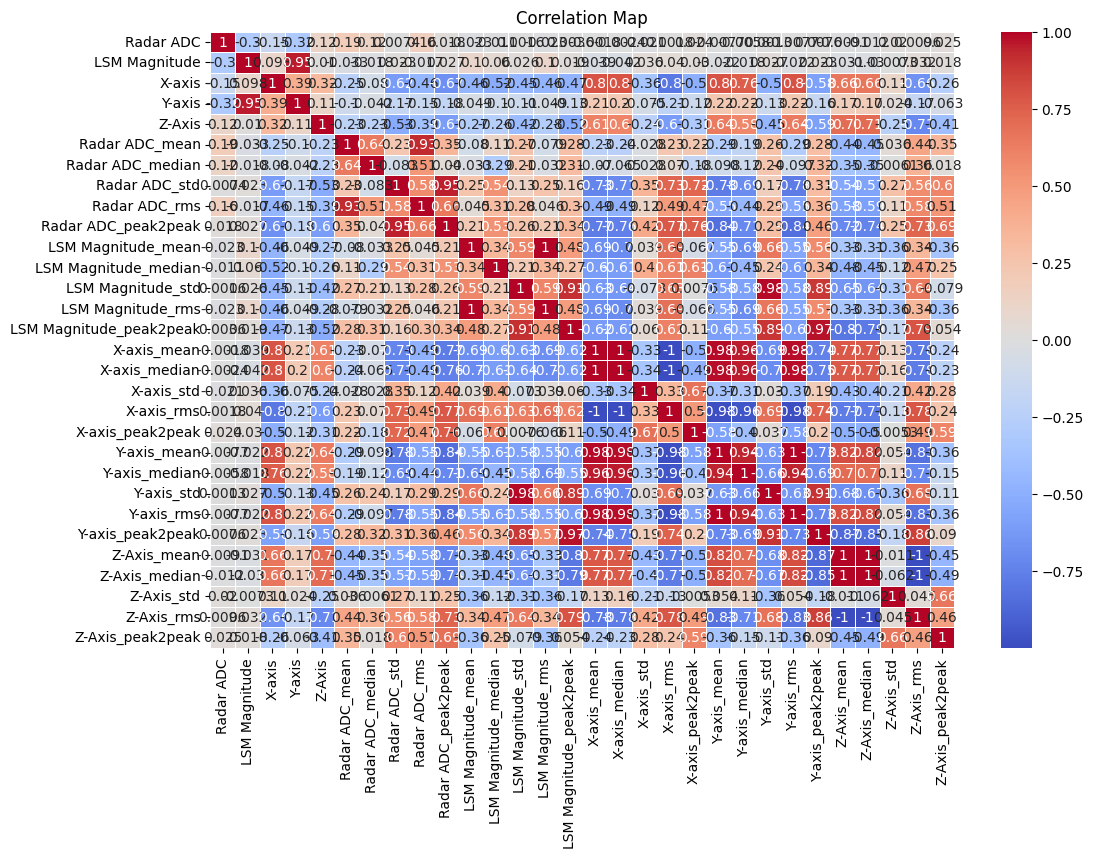

In [ ]:
perform_eda(h_d_with_features)

In [ ]:
h_d_with_features_cleaned = h_d_with_features.dropna()

In [ ]:
for i in h_d_with_features.columns:
    print(i)
    print(h_d_with_features[i].nunique())
    print(h_d_with_features[i].unique())

Radar ADC
774
[2161 2155 2073 2069 2043 2064 2141 2147 2156 2157 2020 1998 2013 2014
 1952 1932 1939 1941 1848 1838 1851 1850 1887 1878 1883 1935 1942 1947
 1944 1908 1928 1923 2090 2103 2099 2108 2148 2131 2135 2040 2028 2010
 2047 2037 2019 2030 2041 2096 2104 2092 2034 2036 2044 2039 1904 1894
 1863 1861 1814 1820 1832 1886 1879 1897 1896 1881 1884 1700 1703 1707
 1699 2082 2107 2300 2305 2310 2308 2223 2216 2233 2217 2349 2352 2356
 2364 2500 2493 2487 2494 2200 2188 2191 2186 2091 2088 2085 2070 1976
 1949 1956 1824 1807 1812 1810 1603 1597 1599 1819 1835 1836 1844 2159
 2143 2115 2124 2114 2012 2021 2024 2162 2166 2164 2163 2236 2239 2248
 2238 2375 2381 2380 2374 2266 2279 2278 2263 2080 2067 1875 1885 1999
 2001 1991 1917 1927 1938 1911 1996 2007 2118 2119 2121 2126 2237 2258
 2252 2257 2400 2383 2376 2391 2128 2110 1869 1868 1856 1731 1739 1734
 1730 2029 2245 2244 2228 2077 2086 1997 2002 1995 2004 2151 2170 2145
 2130 2025 2023 1948 1943 1893 1895 1905 1914 1865 1888 1971 19

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5360 entries, 0 to 5359
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Radar ADC                5360 non-null   int64  
 1   LSM Magnitude            5360 non-null   float64
 2   X-axis                   5360 non-null   float64
 3   Y-axis                   5360 non-null   float64
 4   Z-Axis                   5360 non-null   float64
 5   label                    5360 non-null   object 
 6   Radar ADC_mean           5356 non-null   float64
 7   Radar ADC_median         5356 non-null   float64
 8   Radar ADC_std            5356 non-null   float64
 9   Radar ADC_rms            5356 non-null   float64
 10  Radar ADC_peak2peak      5356 non-null   float64
 11  LSM Magnitude_mean       5356 non-null   float64
 12  LSM Magnitude_median     5356 non-null   float64
 13  LSM Magnitude_std        5356 non-null   float64
 14  LSM Ma

<ipython-input-16-6516439d1087>:33: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=.5)


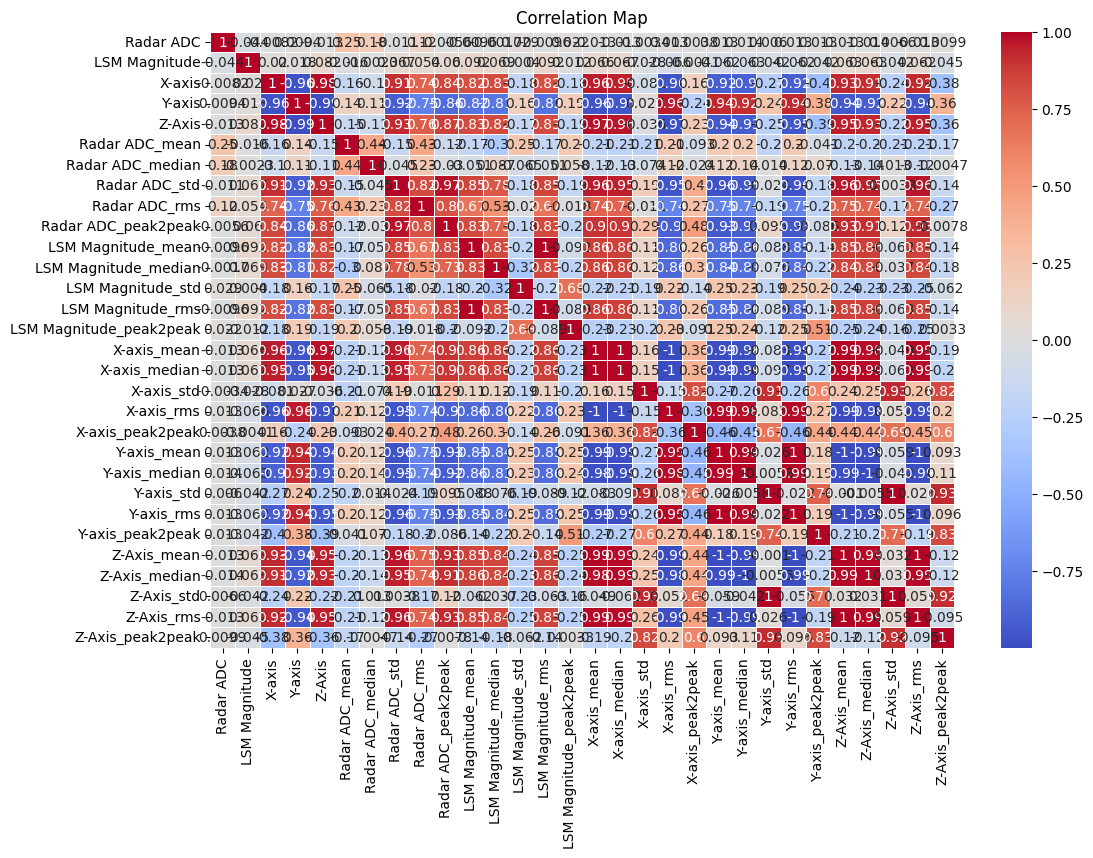

In [ ]:
perform_eda(i_d_with_features)

In [ ]:
i_d_with_features_cleaned = i_d_with_features.dropna()

In [ ]:
for i in i_d_with_features.columns:
    print(i)
    print(i_d_with_features[i].nunique())
    print(i_d_with_features[i].unique())

Radar ADC
1861
[2188 2174 2158 ... 2384 2378 1929]
LSM Magnitude
2013
[0.98505336 0.98474634 0.98211539 ... 0.98737293 0.98781872 0.98607773]
X-axis
277
[-0.46630859 -0.46325684 -0.4609375  -0.46557617 -0.46289062 -0.46508789
 -0.46142578 -0.46191406 -0.46582031 -0.46374512 -0.46435547 -0.45996094
 -0.46130371 -0.46105957 -0.46386719 -0.46081543 -0.46447754 -0.46166992
 -0.46069336 -0.46228027 -0.45898438 -0.46264648 -0.46362305 -0.46276855
 -0.46520996 -0.46728516 -0.46606445 -0.46740723 -0.46252441 -0.46154785
 -0.46569824 -0.4666748  -0.4642334  -0.46643066 -0.46484375 -0.46850586
 -0.46716309 -0.46496582 -0.46472168 -0.46655273 -0.46936035 -0.46411133
 -0.46838379 -0.46911621 -0.46789551 -0.47192383 -0.46875    -0.47033691
 -0.46960449 -0.46887207 -0.47045898 -0.46313477 -0.46777344 -0.46704102
 -0.47106934 -0.46862793 -0.46948242 -0.46813965 -0.46765137 -0.46533203
 -0.4708252  -0.47009277 -0.46899414 -0.47143555 -0.47119141 -0.47058105
 -0.47253418 -0.47094727 -0.47229004 -0.4732

giving labels to the test data

In [ ]:
h_d_with_features_cleaned['label'] = 0
i_d_with_features_cleaned['label'] = 1

<ipython-input-40-bcf33d341bd4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_d_with_features_cleaned['label'] = 0
<ipython-input-40-bcf33d341bd4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_d_with_features_cleaned['label'] = 1


concatenating the test data

In [ ]:
test_data = pd.concat([h_d_with_features_cleaned,
                      i_d_with_features_cleaned,
                      ],
                     ignore_index=True)

In [ ]:
test_data.head()

,Radar ADC,LSM Magnitude,X-axis,Y-axis,Z-Axis,label,Radar ADC_mean,Radar ADC_median,Radar ADC_std,Radar ADC_rms,...,Y-axis_mean,Y-axis_median,Y-axis_std,Y-axis_rms,Y-axis_peak2peak,Z-Axis_mean,Z-Axis_median,Z-Axis_std,Z-Axis_rms,Z-Axis_peak2peak
0,2161,0.982328,-0.208984,0.959839,0.001709,0,2100.200000,2073.0,54.048127,2100.756292,...,0.957422,0.955811,0.002206,0.957424,0.004028,0.000757,0.000122,0.000869,0.001085,0.001587
1,2155,0.982328,-0.208984,0.959839,0.001709,0,2094.166667,2071.0,50.550635,2094.675034,...,0.957153,0.955811,0.002080,0.957155,0.004028,0.000651,0.000122,0.000819,0.000992,0.001587
2,2073,0.978678,-0.210327,0.955811,0.000122,0,2100.857143,2073.0,49.424787,2101.355413,...,0.956717,0.955811,0.002222,0.956720,0.005737,0.000628,0.000122,0.000751,0.000937,0.001587
3,2069,0.978678,-0.210327,0.955811,0.000122,0,2106.625000,2107.0,48.579647,2107.115060,...,0.956390,0.955811,0.002255,0.956393,0.005737,0.000610,0.000305,0.000697,0.000893,0.001587
4,2043,0.978678,-0.210327,0.955811,0.000122,0,2112.111111,2141.0,48.330747,2112.602581,...,0.956136,0.955811,0.002243,0.956138,0.005737,0.000597,0.000488,0.000653,0.000857,0.001587


In [ ]:
test_data.columns

Index(['Radar ADC', 'LSM Magnitude', 'X-axis', 'Y-axis', 'Z-Axis', 'label',
       'Radar ADC_mean', 'Radar ADC_median', 'Radar ADC_std', 'Radar ADC_rms',
       'Radar ADC_peak2peak', 'LSM Magnitude_mean', 'LSM Magnitude_median',
       'LSM Magnitude_std', 'LSM Magnitude_rms', 'LSM Magnitude_peak2peak',
       'X-axis_mean', 'X-axis_median', 'X-axis_std', 'X-axis_rms',
       'X-axis_peak2peak', 'Y-axis_mean', 'Y-axis_median', 'Y-axis_std',
       'Y-axis_rms', 'Y-axis_peak2peak', 'Z-Axis_mean', 'Z-Axis_median',
       'Z-Axis_std', 'Z-Axis_rms', 'Z-Axis_peak2peak'],
      dtype='object')

In [ ]:
train_data.shape

(18107, 31)

In [ ]:
test_data.shape

(7681, 31)

defining selected features

In [ ]:
selected_features = [
    'Z-Axis', 'Z-Axis_rms', 'Z-Axis_mean', 'Radar ADC_std', 'Z-Axis_median',
    'Radar ADC_peak2peak']

defining x_train,y_train,x_test,y_test

In [ ]:
X_train = train_data[selected_features]
y_train = train_data['label']

# Define X and y for test data
X_test = test_data[selected_features]
y_test = test_data['label']

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), selected_features)
    ])

In [ ]:
import os
import pandas as pd
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.base import is_classifier
from sklearn.utils import all_estimators

keras model

In [ ]:
model = keras.Sequential([
    Dense(64, activation='relu', input_shape=(len(selected_features),)),
    Dense(1, activation='sigmoid')  # 3 classes, so use softmax activation
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 513 (2.00 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
for layer in model.layers:
    print(layer.get_config(), layer.input_shape, layer.output_shape)


{'name': 'dense', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 6), 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} (None, 6) (None, 64)
{'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': N

In [ ]:
model.summary(print_fn=print)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 513 (2.00 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


compiling keras model

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

fitting data to the model and training with epochs

In [ ]:
model.fit(X_train, y_train, epochs=10)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/10
566/566 [==============================] - 3s 3ms/step - loss: 1.0767 - accuracy: 0.8820
Epoch 2/10
566/566 [==============================] - 2s 3ms/step - loss: 0.0593 - accuracy: 0.9985
Epoch 3/10
566/566 [==============================] - 2s 3ms/step - loss: 0.0255 - accuracy: 1.0000
Epoch 4/10
566/566 [==============================] - 2s 3ms/step - loss: 0.0137 - accuracy: 1.0000
Epoch 5/10
566/566 [==============================] - 1s 2ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 6/10
566/566 [==============================] - 1s 2ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 7/10
566/566 [==============================] - 1s 2ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 8/10
566/566 [==============================] - 1s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 9/10
566/566 [==============================] - 1s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 10/10
241/241 [==============================] - 1s 1ms/step - loss: 0.1199 - accuracy: 0.9685

In [ ]:
KERAS_MODEL_NAME = "model.h5"
model.save(KERAS_MODEL_NAME)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy is {}%'.format(round(100*test_acc, 2)))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


241/241 - 0s - loss: 0.1199 - accuracy: 0.9685 - 297ms/epoch - 1ms/step

Test accuracy is 96.85%


TFLITE KERAS MODEL

In [ ]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

In [ ]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

3708

check input tensor type

In [ ]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [1 6]
Input Type: <class 'numpy.float32'>
Output Shape: [1 1]
Output Type: <class 'numpy.float32'>


In [ ]:
test_data.shape

(7681, 31)

resize the input tensor shape

In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (7681, 6))
interpreter.resize_tensor_input(output_details[0]['index'], (7681, 1))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [7681    6]
Input Type: <class 'numpy.float32'>
Output Shape: [7681    1]
Output Type: <class 'numpy.float32'>


 the dtype conversion ensures that the input features are in the correct data type (float32) expected by the TensorFlow Lite model. This is important for compatibility and to prevent any potential issues related to data type mismatch during model inference.

In [ ]:
X_test.dtypes

Z-Axis                 float64
Z-Axis_rms             float64
Z-Axis_mean            float64
Radar ADC_std          float64
Z-Axis_median          float64
Radar ADC_peak2peak    float64
dtype: object

In [ ]:
X_test_numpy = np.array(X_test, dtype=np.float32)


In [ ]:
X_test.dtypes

Z-Axis                 float64
Z-Axis_rms             float64
Z-Axis_mean            float64
Radar ADC_std          float64
Z-Axis_median          float64
Radar ADC_peak2peak    float64
dtype: object

In [ ]:
X_test_numpy = np.array(X_test, dtype=np.float32)
X_test = pd.DataFrame(X_test_numpy, columns=X_test.columns)


In [ ]:
X_test.dtypes

Z-Axis                 float32
Z-Axis_rms             float32
Z-Axis_mean            float32
Radar ADC_std          float32
Z-Axis_median          float32
Radar ADC_peak2peak    float32
dtype: object

In [ ]:
interpreter.set_tensor(input_details[0]['index'], X_test)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (7681, 1)


In [ ]:
interpreter.set_tensor(input_details[0]['index'], X_test)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

# Assuming binary classification, directly use the probability scores
probability_scores = tflite_model_predictions.squeeze()  # Remove singleton dimensions
print("Probability Scores:", probability_scores)

# Applying a threshold (e.g., 0.5) to determine the predicted class
threshold = 0.5
binary_predictions = (probability_scores > threshold).astype(int)

# If you want the actual class predictions (0 or 1)
print("Binary Predictions:", binary_predictions)


Prediction results shape: (7681, 1)
Probability Scores: [0.67497385 0.53143907 0.48079866 ... 0.9719118  0.97204065 0.9715055 ]
Binary Predictions: [1 1 0 ... 1 1 1]


In [ ]:
acc = accuracy_score(y_test, binary_predictions)

In [ ]:
print('Test accuracy TFLITE model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE model is 96.85%
